Importing Libraries
--

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Get Data
--

In [2]:
def load_data():
    return pd.read_csv("FlightPrices.csv")
data = load_data()

# Explore the Data

In [3]:
# Insights

data.info()
data.describe()
data.head()

flight = data.copy()
flight.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filghtId          9045 non-null   int64  
 1   airline           9045 non-null   object 
 2   flight            9045 non-null   object 
 3   source_city       9045 non-null   object 
 4   departure_time    9045 non-null   object 
 5   stops             9045 non-null   object 
 6   arrival_time      9045 non-null   object 
 7   destination_city  9045 non-null   object 
 8   duration          9045 non-null   float64
 9   days_left         9045 non-null   int64  
 10  price             9045 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 777.4+ KB


,filghtId,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left,price
0,252589,Vistara,UK-808,Bangalore,Early_Morning,one,Night,Mumbai,13.25,46,69244
1,223754,Vistara,UK-927,Delhi,Morning,one,Evening,Chennai,10.42,31,52392
2,243398,Vistara,UK-988,Mumbai,Night,one,Morning,Chennai,13.00,28,61933
3,208360,Vistara,UK-815,Delhi,Morning,one,Night,Mumbai,12.67,17,53164
4,247226,Vistara,UK-854,Bangalore,Evening,one,Morning,Delhi,13.67,32,42521


In [4]:
# Looking for correlations

cor_matrix = flight.corr()
cor_matrix['price'].sort_values(ascending=False)

price        1.000000
duration     0.229252
filghtId     0.217400
days_left   -0.087552
Name: price, dtype: float64

In [5]:
# Value Counts

def value_counts(data, feature):
    print(data[feature].value_counts())

value_counts(flight, 'stops')

one            8177
zero            771
two_or_more      97
Name: stops, dtype: int64


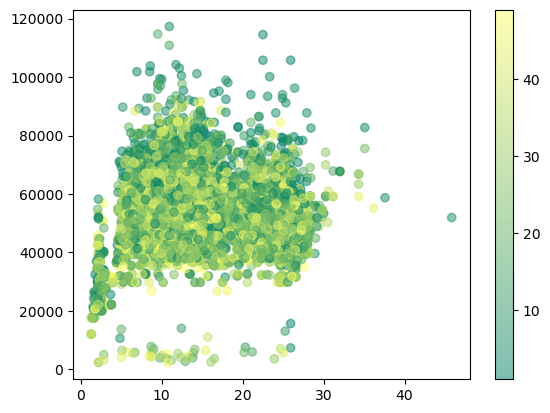

In [6]:
# Visualization

def plot(data, column):
    X_axis = data[column]
    price = data['price']
    color = data['days_left']
    plt.scatter(X_axis, price, alpha=0.5, c=color, cmap=plt.get_cmap('summer'))
    plt.colorbar()

plot(data, 'duration')

# Prepare Data

In [7]:
# Encoding

def transform(data, values):
    data = data.replace(values, [1, 2, 3, 4, 5, 6])
    data = data.replace(['zero', 'one', 'two_or_more'], [0, 1, 2])
    return data

cities = ['Mumbai', 'Delhi', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']
time = ['Night', 'Evening', 'Morning', 'Afternoon', 'Early_Morning', 'Late_Night']
airlines = ['Vistara', 'Air_India', 'Indigo', 'GO_FIRST', 'SpiceJet', 'AirAsia']

flight = transform(flight, cities)
flight = transform(flight, time)
flight = transform(flight, airlines)

In [8]:
# Feature Selection

flight_prepared = flight[['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'duration', 'days_left', 'price']]

In [9]:
# Looking for Correlations

cor_matrix = flight_prepared.corr()
cor_matrix['price'].sort_values(ascending=False)

price               1.000000
stops               0.567568
duration            0.229252
source_city         0.072453
destination_city    0.037392
departure_time     -0.008493
days_left          -0.087552
arrival_time       -0.122944
airline            -0.314964
Name: price, dtype: float64

Creating Test Set
--

In [10]:
# Not a good option

def split_train_set(data, test_size):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_size)
    train_indices = shuffled_indices[test_set_size:]
    test_indices = shuffled_indices[:test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

simple_train_set, simple_test_set = split_train_set(data, 0.25)

In [11]:
# implementing train_test_split from scratch

from zlib import crc32

def test_set_check(identifier, test_size):
    return crc32(np.int64(identifier)) & 0xffffffff < test_size * 2**32
    
    
def split_train_test_by_id(data, test_size):
    ids = data['index']
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_size))
    return data.loc[~in_test_set], data.loc[in_test_set]

data_with_id = data.reset_index()
hash_train_set, hash_test_set = split_train_test_by_id(data_with_id, 0.2)

# Stratified Splitting

Since the stops attribute is strongly correlated with output variable, it would be a better option to split the train and test on the basis of strata rather than using random sampling.

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

for train_index, test_index in split.split(flight_prepared, flight_prepared['stops']):
    strat_train_set = flight_prepared.loc[train_index]
    strat_test_set = flight_prepared.loc[test_index]

In [25]:
flight_train = strat_train_set.copy()
flight_test = strat_test_set.copy()

Creating Train and Test Sets
--

In [26]:
features = flight_train.drop('price', axis=1)
target = flight_train['price']
xTest = flight_test.drop('price', axis=1)
yTest = flight_test['price']

In [133]:
xtr = np.array(features['stops']).reshape(-1, 1)
xt = np.array(xTest['stops']).reshape(-1, 1)

# Scaling

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)

features = scaler.transform(features)
xTest = scaler.fit_transform(xTest)

### Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(features, target)
yPred = lin.predict(xTest)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

lin_rmse = np.sqrt(mean_squared_error(yPred, yTest))
mae = mean_absolute_error(yPred, yTest)
print(f"Linear Regression:-\nRMSE: {lin_rmse} | MAE: {mae}")

Linear Regression:-
RMSE: 9820.400072199136 | MAE: 7398.1027651945


### Decision Tree Regression

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=63)
tree_reg.fit(features, target)

DecisionTreeRegressor(random_state=63)

In [35]:
predictions = tree_reg.predict(xTest)
tree_mse = mean_squared_error(predictions, yTest)
tree_rmse = np.sqrt(tree_mse)
mae = mean_absolute_error(predictions, yTest)
print(f"Decision Regression:-\nRMSE: {tree_rmse} | MAE: {mae}")

Decision Regression:-
RMSE: 8994.69243651507 | MAE: 4587.561912658927


### Random Forest Regression


In [36]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=85, max_depth=5, max_leaf_nodes=10)
rfr.fit(features, target)
predictions = rfr.predict(xTest)

forest_mse = mean_squared_error(predictions, yTest)
forest_rmse = np.sqrt(tree_mse)
forest_mae = mean_absolute_error(predictions, yTest)
print(f"Random Forest Regression:-\nRMSE: {forest_rmse} | MAE: {forest_mae}")

Random Forest Regression:-
RMSE: 8994.69243651507 | MAE: 6806.136527578716


### SVM Regression

In [37]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(features, target)
predictions = svr.predict(xTest)

In [38]:
svr_rmse = np.sqrt(mean_squared_error(predictions, yTest))
svr_mae = mean_absolute_error(predictions, yTest)
print(f"SV Regression:-\nRMSE: {svr_rmse} | MAE: {svr_mae}")

SV Regression:-
RMSE: 12986.333807785315 | MAE: 9675.07945445729


### Ploynomial Regression

In [39]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)
feature_poly = poly_reg.fit_transform(features)

lin_reg = LinearRegression()
lin_reg.fit(feature_poly, target)
predictions = lin_reg.predict(poly_reg.fit_transform(xTest))

poly_rmse = np.sqrt(mean_squared_error(predictions, yTest))
poly_mae = mean_absolute_error(predictions, yTest)
print(f"Polynomial Regression:-\nRMSE: {poly_rmse} | MAE: {poly_mae}")

Polynomial Regression:-
RMSE: 9235.57710487398 | MAE: 6907.614007414374


### SGDRegressor

In [42]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, eta0=0.1, tol=1e-03, penalty='l1', loss='squared_error')
sgd.fit(features, target)
predictions = sgd.predict(xTest)

sgd_rmse = np.sqrt(mean_squared_error(predictions, yTest))
sgd_mae = mean_absolute_error(predictions, yTest)
print(f"SGD Regression:-\nRMSE: {sgd_rmse} | MAE: {sgd_mae}")

SGD Regression:-
RMSE: 9888.382236857271 | MAE: 7464.8775474422755


In [43]:
from sklearn.linear_model import Ridge
lasso_reg = Ridge(alpha=0.1)
lasso_reg.fit(features, target)
predictions = lasso_reg.predict(xTest)

las_rmse = np.sqrt(mean_squared_error(predictions, yTest))
las_mae = mean_absolute_error(predictions, yTest)
print(f"SGD Regression:-\nRMSE: {las_rmse} | MAE: {las_mae}")

SGD Regression:-
RMSE: 9820.39701259458 | MAE: 7398.09850109399
